In this notebook, we are going to apply gradient boosting models such as LightGBMModel and XGBModel from the Darts package. Darts is a useful package developed for analyzing and forecasting time series data, particularly well-suited for multivariate series. The data we will use in this notebook is the weekly ROI corresponding to every day and every hour during the day. Additionally, we will compute weekly ROI for the open, high, and low Bitcoin prices, as we can use these features as past covariates in our model. Another type of past covariants that we consider is the moving average series of the main series (close). We will also include time features like day, month, and year as future covariates. To learn more about the Darts package and its models, see this [user guide](https://unit8co.github.io/darts/userguide/timeseries.html).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from tqdm import tqdm

from darts import TimeSeries
from darts.utils.timeseries_generation import constant_timeseries, datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler, InvertibleMapper, MissingValuesFiller, StaticCovariatesTransformer
from darts.dataprocessing import Pipeline
from sklearn.preprocessing import OneHotEncoder
from darts.models.filtering.moving_average_filter import MovingAverageFilter
from darts.models import LightGBMModel, XGBModel, CatBoostModel
from darts.models import BlockRNNModel, RNNModel

from darts.metrics import rmsle, mae

c:\Users\solmaz\anaconda3\envs\TR\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\solmaz\AppData\Roaming\Python\Python39\site-packages\statsforecast\utils.py:268: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [28]:
df = pd.read_csv("hourly_data_2024_08_02.csv", parse_dates =['time'])
df = df[~df.time.duplicated(keep='first')] # drop duplicated indices
df = df[(df.time >= "2018-01-01") & (df.time <= "2024-07-30")] # To see why we drop old data, see Analysis_Statistcal_Models notebook

In [33]:
def roi_df(dataframe, day, hour):
    df_out = pd.DataFrame()
    columns = ["open", "close", "high", "low"]
    for col in columns:
        df_out["Day_Hour_"+col] = dataframe[(dataframe.index.hour == hour) &(dataframe.index.weekday == day)]["close"] 
        df_out["Next_Day_Hour_"+col] = df_out["Day_Hour_"+col].shift(-1)
        df_out.dropna(inplace = True)
        df_out["7_Day_ROI_"+col]= (df_out['Next_Day_Hour_'+col] - df_out['Day_Hour_'+col]) / df_out['Day_Hour_'+col] * 100
        df_out.drop(columns = ["Day_Hour_"+col, "Next_Day_Hour_"+col], inplace = True)

    return df_out

#df_roi= roi_df(df.set_index('time'), day=0,hour =0)
df_roi = pd.DataFrame()

for d in range(0,8):
    for h in range(0,25):
        df_roi_new= roi_df(df.set_index('time'), day=d, hour = h)
        df_roi = pd.concat([df_roi, df_roi_new])
    

df_roi.index.name = "time"

df_roi = df_roi.sort_values(by='time').reset_index(drop=False)


df_roi

C:\Users\solmaz\AppData\Local\Temp\ipykernel_12648\2695143183.py:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_roi = pd.concat([df_roi, df_roi_new])
C:\Users\solmaz\AppData\Local\Temp\ipykernel_12648\2695143183.py:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  df_roi = pd.concat([df_roi, df_roi_new])
C:\Users\solmaz\AppData\Local\Temp\ipykernel_12648\2695143183.py:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype

,time,7_Day_ROI_open,7_Day_ROI_close,7_Day_ROI_high,7_Day_ROI_low
0,2018-01-01 00:00:00,17.248128,17.248128,17.248128,17.248128
1,2018-01-01 01:00:00,19.399208,19.399208,19.399208,19.399208
2,2018-01-01 02:00:00,19.126910,19.126910,19.126910,19.126910
3,2018-01-01 03:00:00,16.433002,16.433002,16.433002,16.433002
4,2018-01-01 04:00:00,15.253098,15.253098,15.253098,15.253098
...,...,...,...,...,...
56972,2024-07-01 20:00:00,-11.028400,-11.028400,-11.028400,-11.028400
56973,2024-07-01 21:00:00,-10.166123,-10.166123,-10.166123,-10.166123
56974,2024-07-01 22:00:00,-9.909316,-9.909316,-9.909316,-9.909316
56975,2024-07-01 23:00:00,-9.757139,-9.757139,-9.757139,-9.757139


In [8]:

# df_roi.reset_index(drop= True, inplace = True)
# df_roi

In [34]:
df_roi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56977 entries, 0 to 56976
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   time             56977 non-null  datetime64[ns]
 1   7_Day_ROI_open   56977 non-null  float64       
 2   7_Day_ROI_close  56977 non-null  float64       
 3   7_Day_ROI_high   56977 non-null  float64       
 4   7_Day_ROI_low    56977 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 2.2 MB


In [30]:
# duplicate_rows = df_roi[df_roi.duplicated(subset=['time'], keep=False)]
# duplicate_rows

# df_roi = df_roi.drop_duplicates(subset=['time'], keep='first')


In [35]:
df_open = df_roi[["time", "7_Day_ROI_open"]]
df_close = df_roi[["time", "7_Day_ROI_close"]]
df_high = df_roi[["time", "7_Day_ROI_high"]]
df_low = df_roi[["time", "7_Day_ROI_low"]]

df_open

,time,7_Day_ROI_open
0,2018-01-01 00:00:00,17.248128
1,2018-01-01 01:00:00,19.399208
2,2018-01-01 02:00:00,19.126910
3,2018-01-01 03:00:00,16.433002
4,2018-01-01 04:00:00,15.253098
...,...,...
56972,2024-07-01 20:00:00,-11.028400
56973,2024-07-01 21:00:00,-10.166123
56974,2024-07-01 22:00:00,-9.909316
56975,2024-07-01 23:00:00,-9.757139


# Step 1. Load main series and train and test split

In [36]:

split_time_str = "2023-12-31"
split_time = pd.Timestamp(split_time_str)

## load the series
series = TimeSeries.from_dataframe(df_close, 
                                   time_col = 'time',  
                                   value_cols= ["7_Day_ROI_close"],
                                   freq='h', 
                                   fill_missing_dates= True, 
                                   fillna_value= 0)

series = series.astype(np.float64)

## train_test split
train_series, val_series = series.split_after(split_time)

## set train parameter
forecast_horizen = len(val_series)
lags_past_covariate = list(range(-1*forecast_horizen, -1*forecast_horizen-2, -1))

print(forecast_horizen)
print(lags_past_covariate)

4416
[-4416, -4417]


<Axes: xlabel='time'>

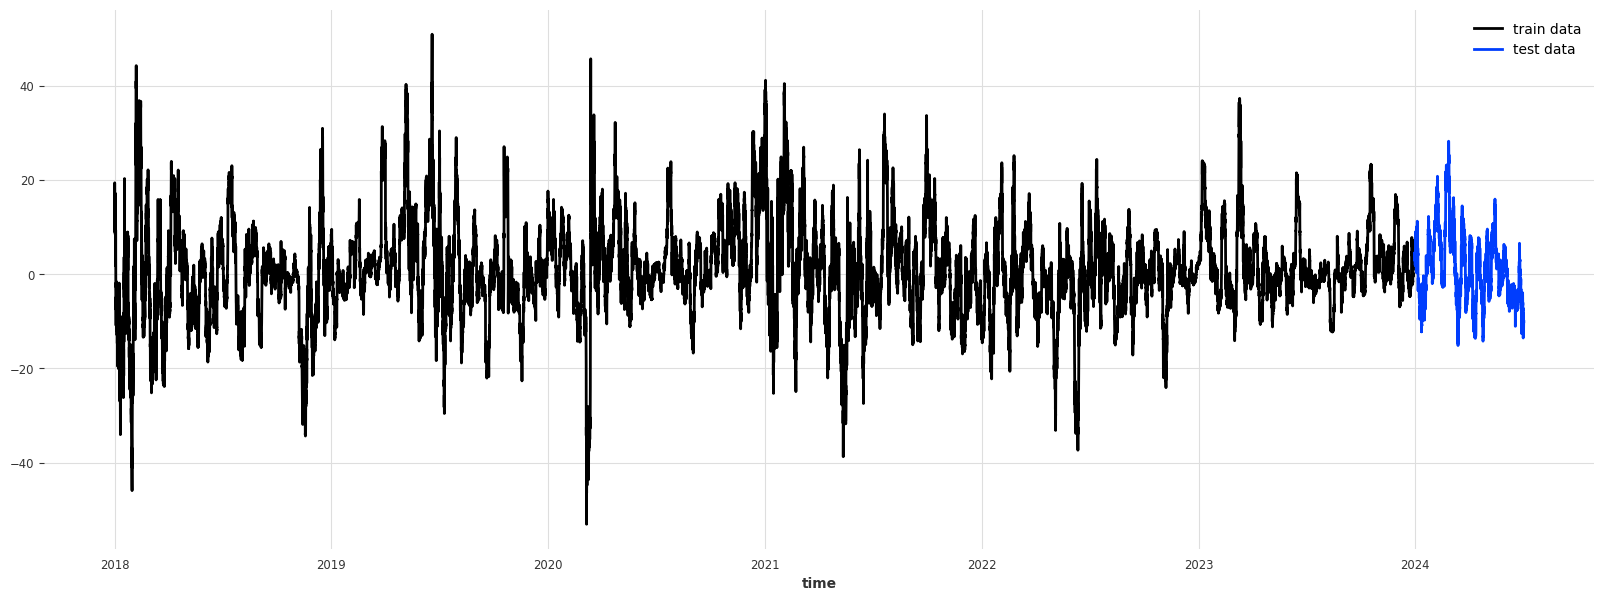

In [37]:
plt.figure(figsize = (20,7))

train_series.plot(label = "train data")
val_series.plot(label = "test data")

In [48]:
print("train series start and end time: ", train_series.start_time(), "--", train_series.end_time())
print("test series start and end time: ", val_series.start_time(), "--", val_series.end_time())

train series start and end time:  2018-01-01 00:00:00 -- 2023-12-31 00:00:00
test series start and end time:  2023-12-31 01:00:00 -- 2024-07-02 00:00:00


# Step 2. Transform train series

In [39]:
def log_transformer(x):
    return np.log(x+150)

def log_inverse_transformer(x):
    return np.exp(x)-150

log_transformer = InvertibleMapper(fn = log_transformer, inverse_fn = log_inverse_transformer, verbose=False, name="Log-Transform")   
log_scaler = Scaler()
log_pipeline = Pipeline([log_transformer, log_scaler])

train_series_transformed = log_pipeline.fit_transform(train_series)

# Step3. Past covariates series


In [40]:

## create open, high and low series

df_open= df_open[df_open.set_index("time").index <= split_time_str]
df_high = df_high[df_high.set_index("time").index <= split_time_str]
df_low = df_low[df_low.set_index("time").index <= split_time_str]

open_ts = TimeSeries.from_dataframe(
    df =df_open,
    time_col= "time",
    value_cols= "7_Day_ROI_open",
    fill_missing_dates= True,
    fillna_value= 0,
    freq= 'h'
    )


high_ts = TimeSeries.from_dataframe(
    df =df_high,
    time_col= "time",
    value_cols= "7_Day_ROI_high",
    fill_missing_dates= True,
    fillna_value= 0,
    freq= 'h'
    )

low_ts = TimeSeries.from_dataframe(
    df =df_low,
    time_col= "time",
    value_cols= "7_Day_ROI_low",
    fill_missing_dates= True,
    fillna_value= 0,
    freq= 'h'
    )

In [41]:
## tranform the open, high and low series
open_scaler_transformation = Scaler()

high_scaler_transformation = Scaler()

low_scaler_transformation = Scaler()

# trans_train, trans_val = transaction_ts_store.split_after(split_time)
open_ts_transform = open_scaler_transformation.fit_transform(open_ts)
high_ts_transform = high_scaler_transformation.fit_transform(high_ts)
low_ts_transform = low_scaler_transformation.fit_transform(low_ts)


## apply MA on the main train series and add the new series as past covariates
ma12 = MovingAverageFilter(window =12)
ma24 = MovingAverageFilter(window =24)
ma168 = MovingAverageFilter(window = 168 )

series_ma12 = ma12.filter(train_series_transformed)
series_ma24 = ma24.filter(train_series_transformed)
series_ma168 = ma168.filter(train_series_transformed)

## define past covariates
past_covs = series_ma12.stack(series_ma24).stack(series_ma168).stack(open_ts_transform).stack(high_ts_transform).stack(low_ts_transform)

# Step4. Add future covariates


In [62]:

## step 4.1. create time-based future covariate

full_time_period = pd.date_range(start=df_roi['time'].min(), end=df_roi['time'].max()+timedelta(days=7), freq='h')

year = datetime_attribute_timeseries(time_index = full_time_period, attribute="year")
month = datetime_attribute_timeseries(time_index = full_time_period, attribute="month")
day = datetime_attribute_timeseries(time_index = full_time_period, attribute="day")
weekday = datetime_attribute_timeseries(time_index = full_time_period, attribute="dayofweek")



time_cov = year.stack(month).stack(day).stack(weekday)#.stack(monthstart).stack(monthend)
time_cov = time_cov.astype(np.float32)

## Transform time_based future covariats
time_cov_scaler = Scaler()

time_cov_transformed = time_cov_scaler.fit_transform(time_cov)

In [63]:
full_time_period

DatetimeIndex(['2018-01-01 00:00:00', '2018-01-01 01:00:00',
               '2018-01-01 02:00:00', '2018-01-01 03:00:00',
               '2018-01-01 04:00:00', '2018-01-01 05:00:00',
               '2018-01-01 06:00:00', '2018-01-01 07:00:00',
               '2018-01-01 08:00:00', '2018-01-01 09:00:00',
               ...
               '2024-07-08 15:00:00', '2024-07-08 16:00:00',
               '2024-07-08 17:00:00', '2024-07-08 18:00:00',
               '2024-07-08 19:00:00', '2024-07-08 20:00:00',
               '2024-07-08 21:00:00', '2024-07-08 22:00:00',
               '2024-07-08 23:00:00', '2024-07-09 00:00:00'],
              dtype='datetime64[ns]', name='time', length=57145, freq='h')

# 5.Final Step. Model Training


`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4901
[LightGBM] [Info] Number of data points in the train set: 48144, number of used features: 23
[LightGBM] [Info] Start training from score 0.606309
MAE validation data: 5.886482968383837


<Axes: xlabel='time'>

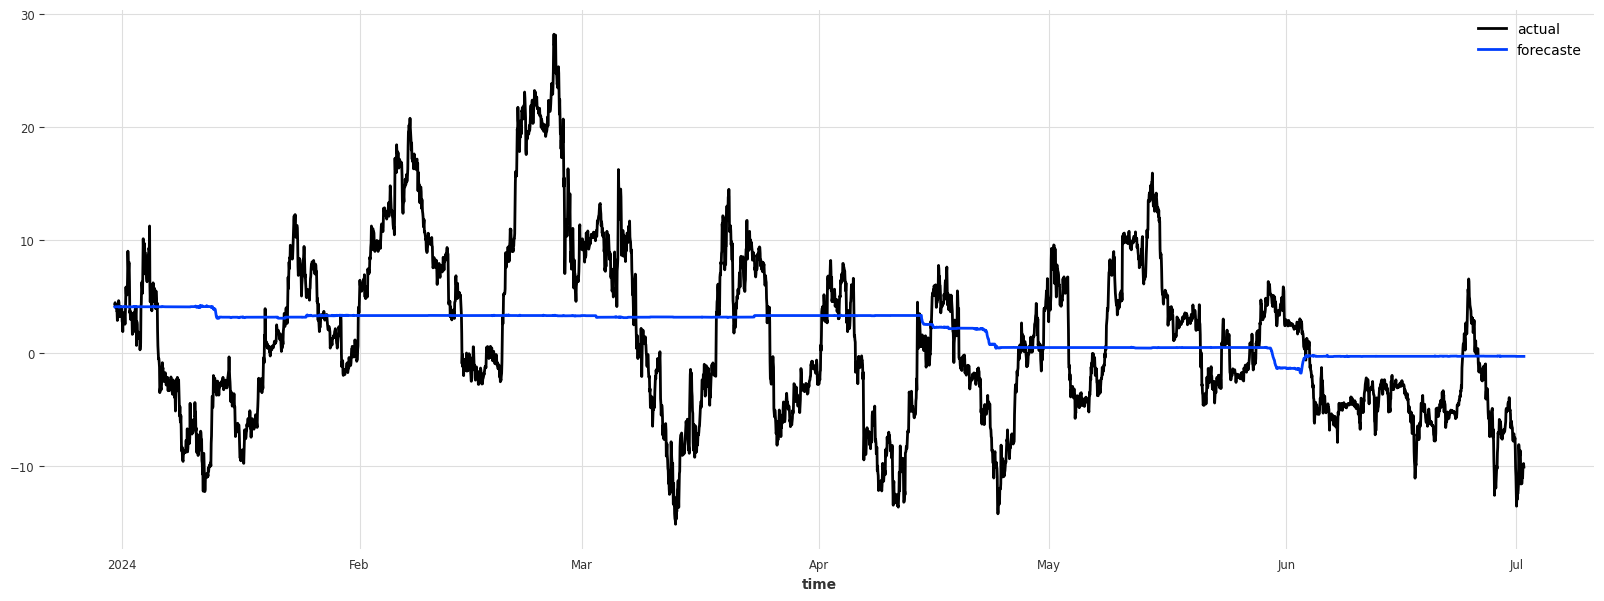

In [70]:
lgbm = LightGBMModel(lags =7, lags_past_covariates= lags_past_covariate, lags_future_covariates= [1], output_chunk_length= 1 )
lgbm.fit(train_series_transformed , past_covariates= past_covs, future_covariates= time_cov_transformed )
y_hat = lgbm.predict(n = len(val_series), series= train_series_transformed, past_covariates= past_covs, future_covariates= time_cov_transformed)
y_hat_inverse = log_pipeline.inverse_transform(y_hat)
y_hat_values =  y_hat_inverse.values()
y_hat_ts = TimeSeries.from_times_and_values(times = val_series.time_index, values= y_hat_values)

#print(rmsle(val_series, y_hat_ts ))
print("MAE validation data:", mae(val_series, y_hat_ts ))


plt.figure(figsize = (20,7))

val_series.plot(label="actual")
y_hat_ts.plot(label="forecaste")

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


MAE of validation data:  5.95303547366469


<Axes: xlabel='time'>

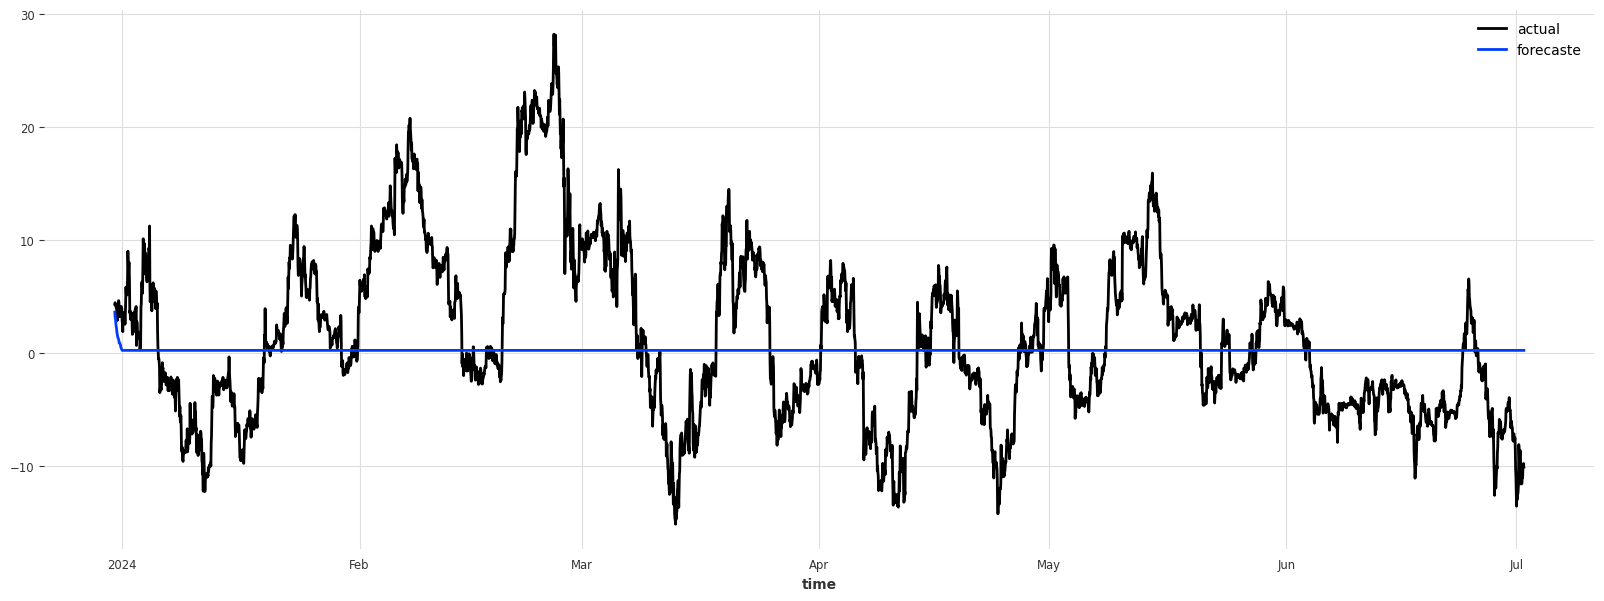

In [71]:
xgb = XGBModel(lags =3, lags_past_covariates= lags_past_covariate, lags_future_covariates= [1], output_chunk_length= 1,
        max_depth=12, 
        min_child_weight = 1,
        learning_rate=0.02, 
        subsample=0.8,
        colsample_bytree=0.4, 
        objective='reg:squaredlogerror',
        n_estimators=1000,
        alpha = 1,
        gamma = 1.5 )
xgb.fit(train_series_transformed , past_covariates= past_covs, future_covariates= time_cov_transformed )
y_hat = xgb.predict(n = len(val_series), series= train_series_transformed, past_covariates= past_covs, future_covariates= time_cov_transformed)
y_hat_inverse = log_pipeline.inverse_transform(y_hat)
y_hat_values =  y_hat_inverse.values()
y_hat_ts = TimeSeries.from_times_and_values(times = val_series.time_index, values= y_hat_values)

#print(rmsle(val_series, y_hat_ts ))
print("MAE of validation data: ", mae(val_series, y_hat_ts ))


plt.figure(figsize = (20,7))

val_series.plot(label="actual")
y_hat_ts.plot(label="forecaste")

The gradient boosted trees didn’t perform much better than the statistical models, so we won't use them for inference.